In [1]:
import os
import glob
import numpy as np
from scipy import signal
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.metrics import confusion_matrix

from utils import plot_confusion_matrix

In [2]:
AUDIO_BASEPATH = 'data/measurment-2/raw/'
AUDIO_FILE = '230428-003.wav'

audio_path = os.path.join(AUDIO_BASEPATH, AUDIO_FILE)

In [3]:
CALIBRATION_BASEPATH = 'data/measurment-2/calibrations/'
CALIBRATION_FILE = '230428-004-calibration-30dB.wav'

calibration_path = os.path.join(CALIBRATION_BASEPATH, CALIBRATION_FILE)

In [4]:
audio, sr = librosa.load(audio_path, sr=None, mono=False)
audio = audio[0,:]

length = audio.shape[0] / sr

print('Audio length: {:.2f} seconds'.format(length))
print('Sample rate: {} Hz'.format(sr))

Audio length: 1568.49 seconds
Sample rate: 48000 Hz


In [5]:
REF_EFF = 20e-5 # Pa
CAL_SPL = 123.8 # dB

def calculate_calibration_gain(calibration_path, ref_eff=REF_EFF, cal_spl=CAL_SPL, printing=True):
    calibration, sr = librosa.load(calibration_path, sr=None, mono=True)
    length = calibration.shape[0] / sr
    
    calibration_rms = np.sqrt(np.mean(calibration**2))
    calibration_rms_db = 20 * np.log10(calibration_rms / 1)
    calibration_spl = 20 * np.log10(calibration_rms / ref_eff)

    gain_db = calibration_spl - cal_spl
    calibration_gain = 10**(gain_db / 20)

    if printing:
        print(f'Calibration file: {calibration_path}')
        print(f'Calibration length: {length:.2f} seconds')
        print(f'Calibration RMS: {calibration_rms_db:.2f} dB (ref 1 Pa)')
        print(f'Calibration SPL: {calibration_spl:.2f} dB (ref 20 uPa)')
        print(f'Calibration gain: {gain_db:.2f} dB ({calibration_gain})')
        print()
    
    return calibration_gain

calibration_gain = calculate_calibration_gain(calibration_path)

Calibration file: data/measurment-2/calibrations/230428-004-calibration-30dB.wav
Calibration length: 5.88 seconds
Calibration RMS: -9.76 dB (ref 1 Pa)
Calibration SPL: 64.22 dB (ref 20 uPa)
Calibration gain: -59.58 dB (0.0010497809295782082)



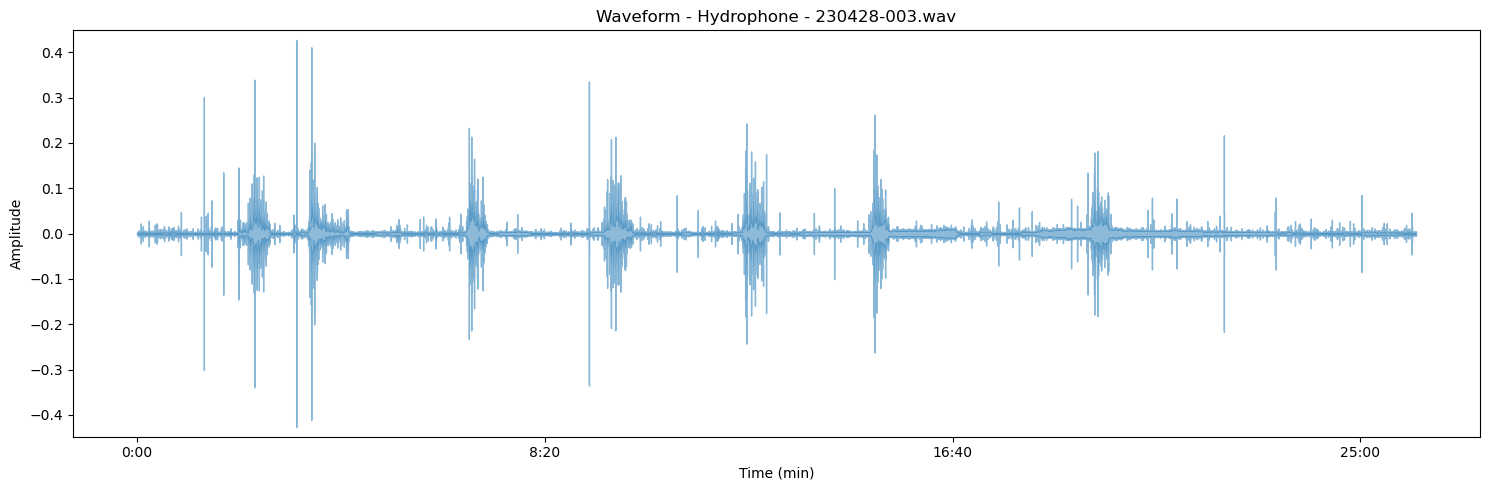

In [6]:
y_max = np.max(np.abs(audio)) * 1.05

plt.figure(figsize=(15, 5))

librosa.display.waveshow(audio, sr=sr, alpha=0.5)
plt.ylim(-y_max, y_max)
plt.title(f'Waveform - Hydrophone - {AUDIO_FILE}')
plt.ylabel('Amplitude')
time_unit = 'min' if audio.shape[0] / sr > 60 else 's'
plt.xlabel(f'Time ({time_unit})')

plt.tight_layout()

plt.show()

In [7]:
NFFT = 1024
HOP_LENGTH = 512
TOP_DB = 80

spectrogram = librosa.stft(audio, n_fft=NFFT, hop_length=HOP_LENGTH)
spectrogram_dB = librosa.amplitude_to_db(np.abs(spectrogram), top_db=TOP_DB, ref=1) - 20 * np.log10(calibration_gain)

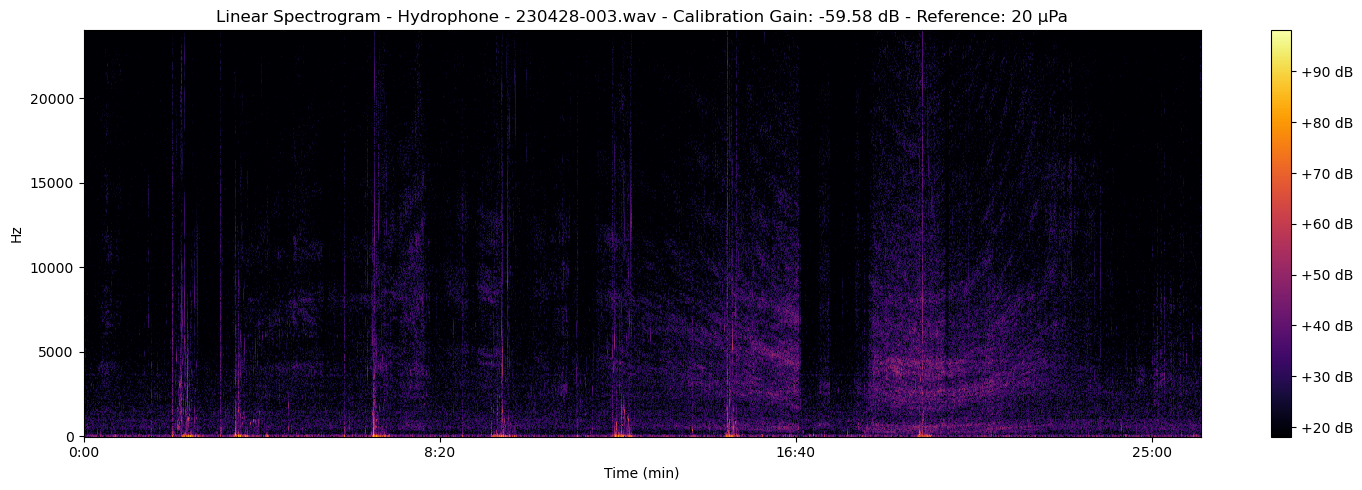

In [8]:
plt.figure(figsize=(15, 5))

im = librosa.display.specshow(spectrogram_dB, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear', cmap='inferno')
plt.colorbar(im, format='%+2.0f dB')
plt.title(f'Linear Spectrogram - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
time_unit = 'min' if spectrogram_dB.shape[1] / sr * HOP_LENGTH > 60 else 's'
plt.xlabel(f'Time ({time_unit})')

plt.tight_layout()

plt.show()

In [9]:
FRAME_SIZE = int(sr * 0.125) # 125 ms (fast RMS)
HOP_LENGTH = FRAME_SIZE // 2

audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
time = librosa.times_like(audio_spl, sr=sr, hop_length=HOP_LENGTH)

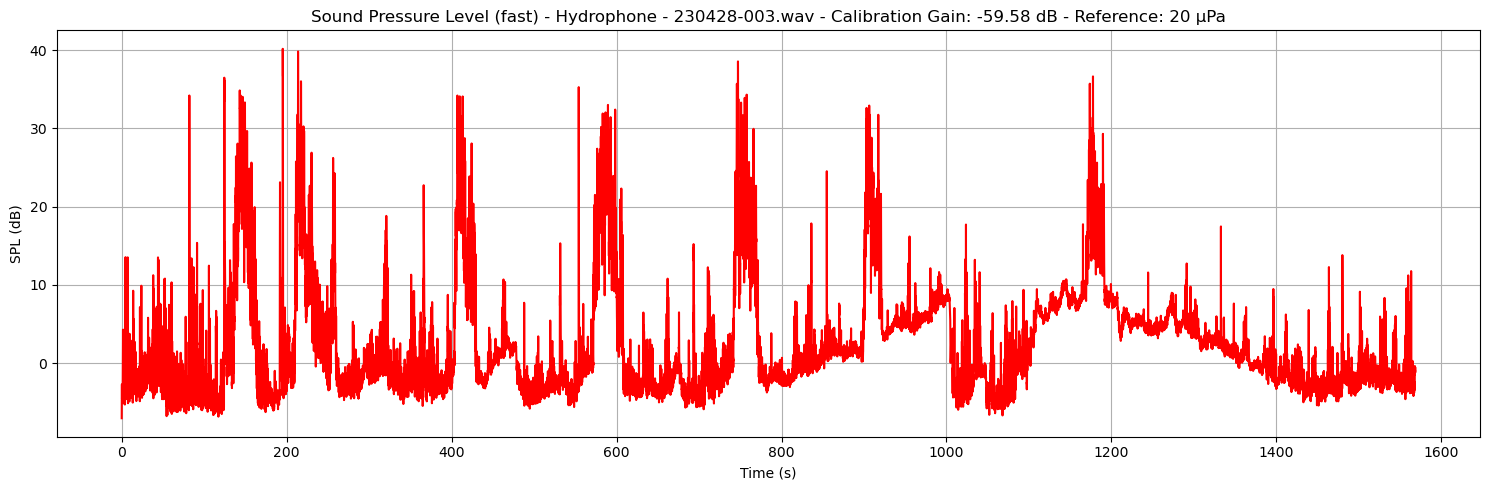

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(time, audio_spl, color='red')
plt.title(f'Sound Pressure Level (fast) - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
plt.xlabel('Time (s)')
plt.ylabel('SPL (dB)')
plt.grid()

plt.tight_layout()

plt.show()

In [11]:
LOWER_FREQ = 5000
UPPER_FREQ = sr / 2 - 1
FILTER_TYPE = 'bandpass'
ORDER = 4

b, a = signal.butter(ORDER, [LOWER_FREQ, UPPER_FREQ], btype=FILTER_TYPE, fs=sr)
filtered_audio = signal.filtfilt(b, a, audio)

In [12]:
spectrogram = librosa.stft(filtered_audio, n_fft=NFFT, hop_length=HOP_LENGTH)
spectrogram_dB = librosa.amplitude_to_db(np.abs(spectrogram), top_db=TOP_DB, ref=1) - 20 * np.log10(calibration_gain)

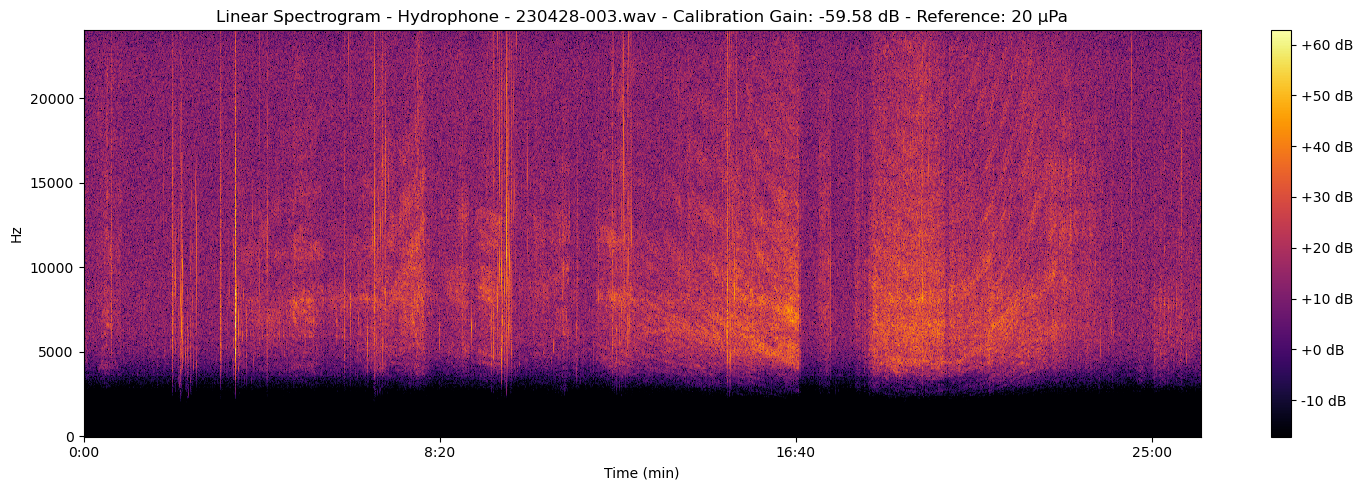

In [13]:
plt.figure(figsize=(15, 5))

im = librosa.display.specshow(spectrogram_dB, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear', cmap='inferno')
plt.colorbar(im, format='%+2.0f dB')
plt.title(f'Linear Spectrogram - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
time_unit = 'min' if spectrogram_dB.shape[1] / sr * HOP_LENGTH > 60 else 's'
plt.xlabel(f'Time ({time_unit})')

plt.tight_layout()

plt.show()

In [14]:
FRAME_SIZE = int(sr * 0.125) # 125 ms (fast RMS)
HOP_LENGTH = FRAME_SIZE // 2

audio_rms = librosa.feature.rms(y=filtered_audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
time = librosa.times_like(audio_spl, sr=sr, hop_length=HOP_LENGTH)

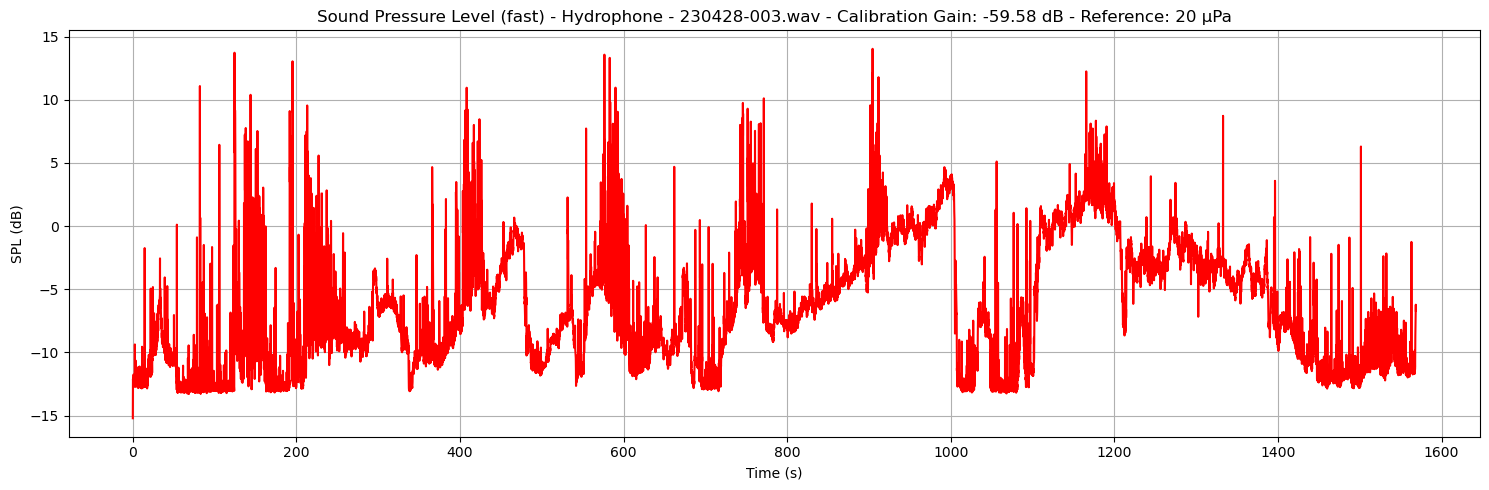

In [15]:
plt.figure(figsize=(15, 5))

plt.plot(time, audio_spl, color='red')
plt.title(f'Sound Pressure Level (fast) - Hydrophone - {AUDIO_FILE} - Calibration Gain: {20 * np.log10(calibration_gain):.2f} dB - Reference: 20 \u03bcPa')
plt.xlabel('Time (s)')
plt.ylabel('SPL (dB)')
plt.grid()

plt.tight_layout()

plt.show()

In [16]:
AUDIO_CLIP_WAV_FOLDER = 'data/measurment-2/clips/wav/'
AUDIO_CLIP_TXT_FOLDER = 'data/measurment-2/clips/txt/'

In [17]:
data_paths = glob.glob(AUDIO_CLIP_WAV_FOLDER + '*.wav')
label_paths = glob.glob(AUDIO_CLIP_TXT_FOLDER + '*.txt')

data_paths = list(sorted(data_paths))
label_paths = list(sorted(label_paths))

datas = list()
labels = list()

for data_path, label_path in zip(data_paths, label_paths):
    audio, sr = librosa.load(data_path, sr=None, mono=False)
    datas.append(audio)
    
    with open(label_path, 'r') as f:
        label = f.readlines()
        label = [l.strip() for l in label]

        if 'JUMP' in label:
            label = 'JUMP'
        else:
            label = 'BACKGROUND'
        labels.append(label)

In [18]:
UPPER_THRESHOLD = 37
LOWER_THRESHOLD = 16
DETECTION_WINDOW = 1

predicted_labels = list()

for audio in datas:
    audio_rms = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
    audio_spl = librosa.amplitude_to_db(audio_rms, ref=1).reshape(-1) - 20 * np.log10(calibration_gain)
    
    max_spl = np.max(audio_spl)
    
    if LOWER_THRESHOLD < max_spl < UPPER_THRESHOLD:
        predicted_labels.append('JUMP')
    else:
        predicted_labels.append('BACKGROUND')
        
predicted_labels = np.array(predicted_labels)

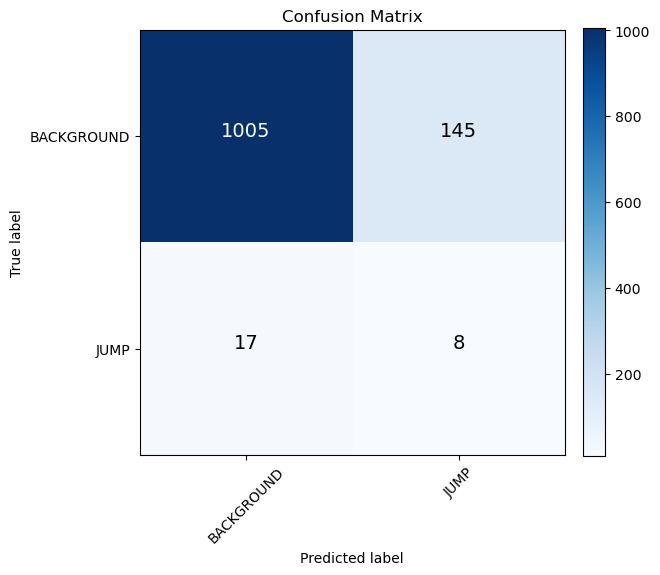

In [19]:
cm = confusion_matrix(labels, predicted_labels, labels=['BACKGROUND', 'JUMP'])
plot_confusion_matrix(cm, classes=['BACKGROUND', 'JUMP'], title='Confusion Matrix')

In [20]:
cm

array([[1005,  145],
       [  17,    8]])

In [21]:
sequences = list()

start = None

for idx, label in enumerate(labels):
    if start is None and label == 'JUMP':
        start = idx
    
    if start is not None and label == 'BACKGROUND':
        sequences.append((start, idx))
        start = None
        
sequences

[(92, 96),
 (143, 147),
 (273, 276),
 (397, 400),
 (519, 521),
 (625, 628),
 (819, 822),
 (1046, 1049)]

In [22]:
for sequence in sequences:
    start = sequence[0]
    end = sequence[1]
    
    if np.where(predicted_labels[start:end] == 'JUMP')[0].shape[0] > 0:
        print(f'Jump detected in sequence {start} - {end}')

Jump detected in sequence 92 - 96
Jump detected in sequence 143 - 147
Jump detected in sequence 273 - 276
Jump detected in sequence 397 - 400
Jump detected in sequence 625 - 628
